In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Declare a Base using `automap_base()`
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base() 

# reflect the tables
Base.prepare(engine, reflect=True) 

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Determine the date of the last data point and store it as a string

q_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
latest_date_str = q_latest_date[0]
print(latest_date_str)

2017-08-23


In [11]:
# Convert the last data point to a date

latest_date_dt = dt.datetime.strptime(latest_date_str,"%Y-%m-%d").date()
print(latest_date_dt)


2017-08-23


In [12]:
# Create and store a variable for holding the date one year ago from the last data point

year_ago_date_dt = latest_date_dt - dt.timedelta(days=365)
print(year_ago_date_dt)

2016-08-23


In [13]:
# Perform a query to retrieve the date and precipitation scores for the past year's data

past_year_data = session.query(Measurement).\
    filter(Measurement.date > year_ago_date_dt).all()

# Create empty lists to store the date and precipitation scores
past_year_date_list = []
past_year_prcp_list = []

# Populate lists with the past year's data
for row in past_year_data:
    past_year_date_list.append(row.date)
    past_year_prcp_list.append(row.prcp)
    
#past_year_date_list
#past_year_prcp_list

In [14]:
# Create a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(past_year_prcp_list, index = past_year_date_list, columns = ['Precipitation'])

# Drop null values for precipitation
df = df.dropna()

# Sort the dataframe by date
df_sorted = df.sort_index(axis = 0)

#df
df_sorted

,Precipitation
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.00


Text(0.5, 1.0, 'Daily Rainfall at Various Stations (2016-08-23 to 2017-08-23)')

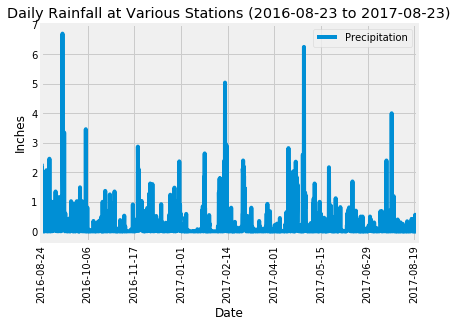

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

df_sorted.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title(f"Daily Rainfall at Various Stations ({year_ago_date_dt} to {latest_date_dt})")

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sorted.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} measurement stations.")

There are 9 measurement stations.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_groups = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc())

for i in station_groups:
    print(f"Station {i[0]} had {i[1]} measurements.")

Station USC00519281 had 2772 measurements.
Station USC00519397 had 2724 measurements.
Station USC00513117 had 2709 measurements.
Station USC00519523 had 2669 measurements.
Station USC00516128 had 2612 measurements.
Station USC00514830 had 2202 measurements.
Station USC00511918 had 1979 measurements.
Station USC00517948 had 1372 measurements.
Station USC00518838 had 511 measurements.


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station_id = station_groups.first()[0]

temp_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()[0][0]
temp_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()[0][0]
temp_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()[0][0]

print(f"The lowest temperature recorded at Station {most_active_station_id} was {temp_min}.")
print(f"The highest temperature recorded at Station {most_active_station_id} was {temp_max}.")
print(f"The average temperature recorded at Station {most_active_station_id} was {temp_avg}.")

The lowest temperature recorded at Station USC00519281 was 54.0.
The highest temperature recorded at Station USC00519281 was 85.0.
The average temperature recorded at Station USC00519281 was 71.66378066378067.


Text(0.5, 1.0, 'Daily Temp (F) Frequency at Station USC00519281')

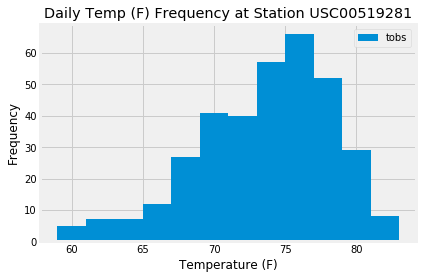

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_past_year_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date > year_ago_date_dt).\
    filter(Measurement.station == most_active_station_id).all()

df2 = pd.DataFrame(most_active_past_year_tobs, columns = ['tobs'])
df2.plot(kind='hist',bins=12)
plt.xlabel("Temperature (F)")
plt.title(f"Daily Temp (F) Frequency at Station {most_active_station_id}")

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
